In [23]:
import pandas as pd

In [24]:
enade_2023 = pd.read_excel("data/conceito_enade_2023.xlsx")
enade_2023 = enade_2023[:9813]

In [25]:
enade_2021 = pd.read_excel("data/conceito_enade_2021.xlsx")
media_enade_2021 = enade_2021.rename(
    columns={
        "Sigla da IES*": "sigla", 
        "Conceito Enade (Contínuo)": "conceito",
        "Ano": "ano",
    }).groupby(by=["ano", "sigla"])[["conceito"]].mean().reset_index()

In [26]:
enade_2022 = pd.read_excel("data/conceito_enade_2022.xlsx")
media_enade_2022 = enade_2022.rename(
    columns={
        "Sigla da IES*": "sigla", 
        "Conceito Enade (Contínuo)": "conceito",
        "Ano": "ano",
    }).groupby(by=["ano", "sigla"])[["conceito"]].mean().reset_index()

In [27]:
rota = pd.read_parquet("data/dados_organizados.parquet")

In [28]:
media_enade_2023 = enade_2023.rename(
    columns={
        "Sigla da IES*": "sigla", 
        "Conceito Enade (Contínuo)": "conceito",
        "Ano": "ano",
    }).groupby(by=["ano", "sigla"])[["conceito"]].mean().reset_index()

In [29]:
enade_total = pd.concat([media_enade_2021, media_enade_2022, media_enade_2023])

In [30]:
# df_merge = rota.merge(media_enade[["ano", "sigla", "conceito"]], how="left", on=["ano", "sigla"])
df_merge = rota.merge(enade_total[["ano", "sigla", "conceito"]], how="left", on=["ano", "sigla"])
# df_merge_3 = rota.merge(media_enade_2021[["ano", "sigla", "conceito"]], how="left", on=["ano", "sigla"])

In [31]:
df_filtrado = df_merge[df_merge.conceito.isnull() == False]
df_taxas = df_filtrado.assign(
    taxa_desligamento=(df_filtrado.aposentadorias + df_filtrado.desligamentos)/df_filtrado.servidores, 
    taxa_contratacao=(df_filtrado.contratação_pms + df_filtrado.contratação_pmss)/df_filtrado.servidores,
)
df_taxas = df_taxas[df_taxas.taxa_contratacao < 0.25]
df_taxas = df_taxas.groupby("sigla")[["conceito", "taxa_desligamento", "taxa_contratacao"]].mean()
# df_taxas.plot.scatter(x="conceito", y="taxa_desligamento")
# df_taxas.plot.scatter(x="conceito", y="taxa_contratacao")

In [32]:
from scipy.stats import spearmanr, pearsonr


print("-- Pearson --")
sig_des_p = pearsonr(df_taxas["taxa_desligamento"].to_numpy(), df_taxas["conceito"].to_numpy())
print(f"Taxa de desligamento - Correlação: {sig_des_p[0]}", f"  p-value: {sig_des_p[1]}")
sig_cont_p =pearsonr(df_taxas["taxa_contratacao"].to_numpy(), df_taxas["conceito"].to_numpy())
print(f"Taxa de contratação - Correlação: {sig_cont_p[0]}", f"  p-value: {sig_cont_p[1]}\n")

print("-- Spearman -- ")
sig_des_s = spearmanr(df_taxas["taxa_desligamento"].to_numpy(), df_taxas["conceito"].to_numpy())
print(f"Taxa de desligamento - Correlação: {sig_des_s[0]}", f"  p-value: {sig_des_s[1]}")
sig_cont_s = spearmanr(df_taxas["taxa_contratacao"].to_numpy(), df_taxas["conceito"].to_numpy())
print(f"Taxa de contratação - Correlação: {sig_cont_s[0]}", f"  p-value: {sig_cont_s[1]}")

-- Pearson --
Taxa de desligamento - Correlação: 0.3230490767878384   p-value: 0.018304564191207535
Taxa de contratação - Correlação: -0.15500425380688598   p-value: 0.267752006226083

-- Spearman -- 
Taxa de desligamento - Correlação: 0.33809063054346067   p-value: 0.01328503101894915
Taxa de contratação - Correlação: -0.20730527334300916   p-value: 0.13636855480274246


<Axes: title={'center': 'pearson = -0.15500\nspearman = -0.20731'}, xlabel='conceito', ylabel='taxa_contratacao'>

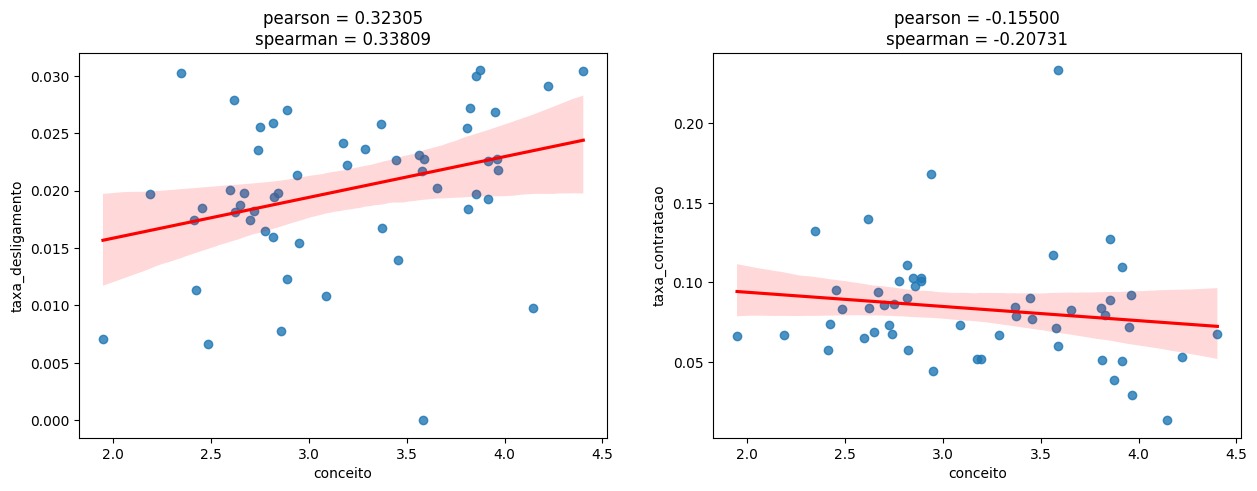

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotando um gráfico para representar a correlação
ax1.set_title(f"pearson = {sig_des_p[0]:.5f}\nspearman = {sig_des_s[0]:.5f}")
sns.regplot(
    y=df_taxas["taxa_desligamento"], 
    x=df_taxas["conceito"], 
    line_kws={"color": "red"},
    ax=ax1
)

ax2.set_title(f"pearson = {sig_cont_p[0]:.5f}\nspearman = {sig_cont_s[0]:.5f}")
sns.regplot(
    x=df_taxas["conceito"],
    y=df_taxas["taxa_contratacao"],
    line_kws={"color": "red"},
    ax=ax2
)